# Review: Monte-Carlo Dropout for Uncertainty Estimation in Deep Learning

## 0. Libraries & Setup

In [1]:
# deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F

# data
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# other
import tqdm as tqdm

Setup the device for the training:

In [2]:
# Set device
if ((int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13)) and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

mps


Finally, a function that contains some noise:

In [3]:
# Define the function to be modeled
def f(x):
    return x + np.random.normal(0, 0.1, x.shape[0]) * x ** 2

# Generate input data
X = np.linspace(0, 5, num=1000, endpoint=True)

# Generate target data using the function f(x)
y = f(X)

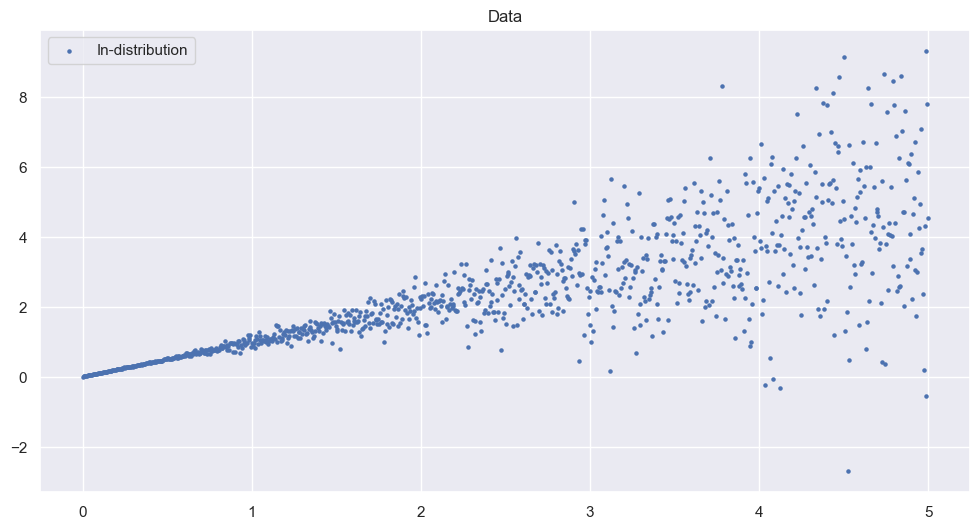

In [4]:
# plot 
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, s=5, label="In-distribution")
plt.legend()
plt.title("Data")
plt.show()

The function is linear with some Gaussian noise added to it that increases with the input value (cone shape).

In [5]:
# Make batch data 
def make_batch(data_size, sample_size, data_x, data_y):
    # Make batches(testing)
    batch_idx = np.random.choice(data_size, sample_size)
    
    batch_x = np.zeros([sample_size, 1])
    batch_y = np.zeros([sample_size, 1])
        
    for i in range(batch_idx.shape[0]):
        batch_x[i,:] = data_x[batch_idx[i]]
        batch_y[i,:] = data_y[batch_idx[i]] 
    
    batch_x = torch.FloatTensor(batch_x).to(device)
    batch_y = torch.FloatTensor(batch_y).to(device)
    
    return batch_x, batch_y  

## I. Monte-Carlo Dropout

The first method is to use Monte-Carlo Dropout as explained in the paper: 
[Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning](https://arxiv.org/pdf/1506.02142v6.pdf).

In this paper, the author shows that a neural network with arbitrary depth and non-linearities, with dropout applied before each weight layer is mathematically equivalent to an approximation to the probabilistic Gaussian process.

Furthermore, this method as opposed to Bayesian Neural Network, is computationally efficient and can be applied to any neural network architecture.

In [6]:
class MC_Dropout_net(nn.Module):
    def __init__(self, p: int = 0.25) -> None:
        super().__init__()
        
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)
        
        self.dropout = nn.Dropout(p=p)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = self.fc3(x)
        
        return x

Setup some training parameters:

In [7]:
model = MC_Dropout_net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas=(0.9, 0.999))
criterion = nn.MSELoss()

Training loop:

In [8]:
for i in tqdm.tqdm(range(1_000)):
    model.train()
    optimizer.zero_grad()
    
    # create a batch
    batch_x, batch_y = make_batch(X.shape[0], 32, X, y)
    
    # forward pass
    preds = model(batch_x)
    
    # calculate loss
    loss = criterion(preds, batch_y)
    
    # backward pass
    loss.backward()
    
    # update parameters
    optimizer.step()
    
    # print loss
    if i % 100 == 0:
        print("Epoch: {0}, Loss: {1}".format(i, loss.item()))

  2%|▏         | 24/1000 [00:00<00:09, 103.14it/s]

Epoch: 0, Loss: 10.945655822753906


 14%|█▍        | 139/1000 [00:00<00:04, 212.38it/s]

Epoch: 100, Loss: 1.309982419013977


 23%|██▎       | 233/1000 [00:01<00:03, 226.08it/s]

Epoch: 200, Loss: 1.9834911823272705


 33%|███▎      | 328/1000 [00:01<00:03, 223.47it/s]

Epoch: 300, Loss: 4.03782320022583


 45%|████▍     | 448/1000 [00:02<00:02, 233.85it/s]

Epoch: 400, Loss: 2.1000475883483887


 54%|█████▍    | 544/1000 [00:02<00:01, 235.69it/s]

Epoch: 500, Loss: 1.3011397123336792


 64%|██████▍   | 640/1000 [00:02<00:01, 231.14it/s]

Epoch: 600, Loss: 1.749098777770996


 74%|███████▎  | 736/1000 [00:03<00:01, 235.57it/s]

Epoch: 700, Loss: 2.3315258026123047


 83%|████████▎ | 832/1000 [00:03<00:00, 235.80it/s]

Epoch: 800, Loss: 0.9005686640739441


 93%|█████████▎| 928/1000 [00:04<00:00, 235.25it/s]

Epoch: 900, Loss: 0.9111670255661011


100%|██████████| 1000/1000 [00:04<00:00, 221.92it/s]


Function that estimates the uncertainty:

In [9]:
def uncertainity_estimate(x, model, num_samples):
    outputs = np.hstack([model(x).cpu().detach().numpy() for i in range(num_samples)])
    y_mean = outputs.mean(axis=1)
    y_variance = outputs.var(axis=1)
    y_std = np.sqrt(y_variance)
    return outputs, y_mean, y_std

In [10]:
samples = 100
# compute predictions

# Get Unknown dataset and test
x_sample = np.arange(0, 10 + 0.1, 0.1)
X_sample = np.reshape(x_sample, [x_sample.shape[0], 1])

X_sample_tensor = torch.from_numpy(X_sample).float().to(device)

In [11]:
iters_uncertainty = 200

n_std = 2 # number of standard deviations to plot
outputs, y_mean, y_std = uncertainity_estimate(X_sample_tensor, model, iters_uncertainty)

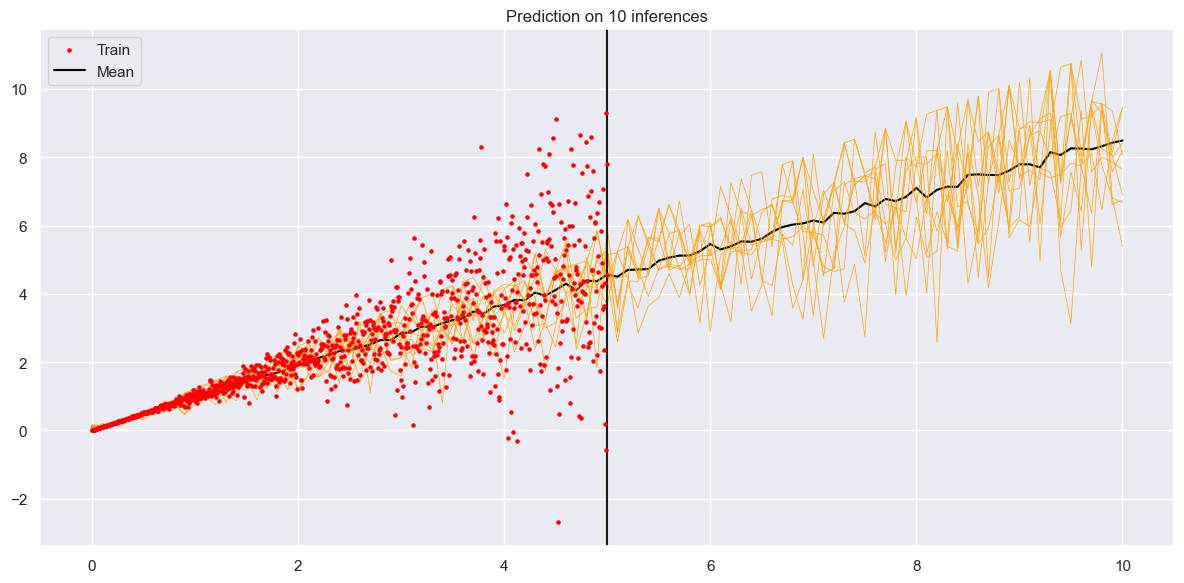

In [12]:
# plot
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
# plt.scatter(X_test, y_test, color="blue", zorder=10, label="Test", s=5)
plt.plot(x_sample, y_mean, color="black", label="Mean")

for i in range(10):
    plt.plot(x_sample, outputs[:, i], color="orange", linewidth=0.5)

plt.legend(loc="upper left")
plt.axvline(x=5, color='k')
plt.title('Prediction on 10 inferences')
plt.tight_layout()
plt.show()

## II. Uncertainty Estimation

Now, we can plot the uncertainty of the model:

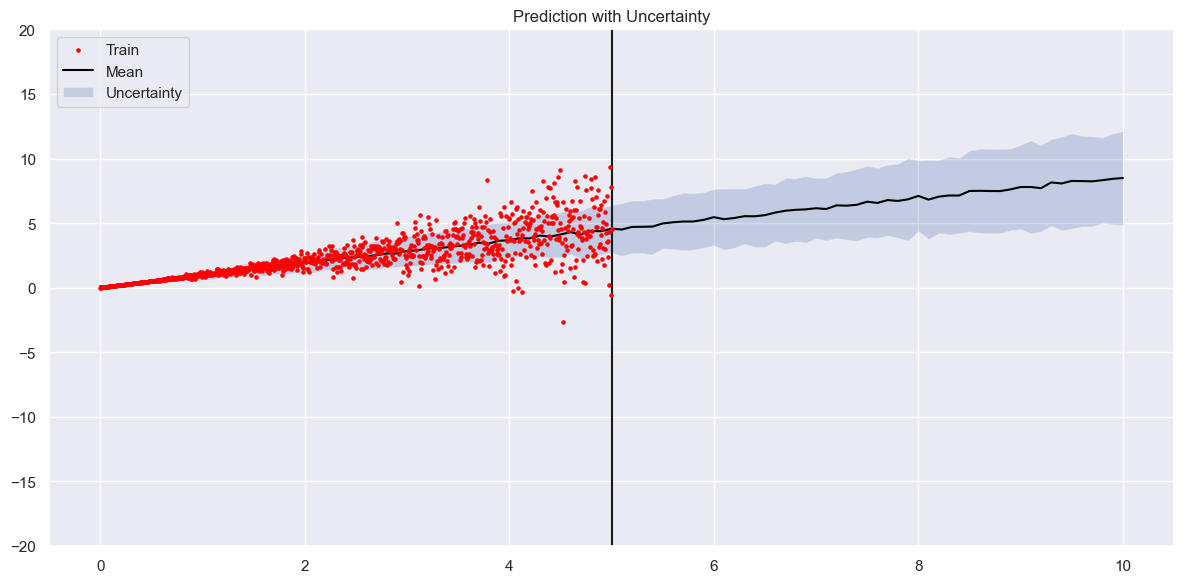

In [13]:
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
plt.plot(x_sample, y_mean, color="black", label="Mean")
plt.fill_between(x_sample, y_mean - n_std * y_std, y_mean + n_std * y_std, alpha=0.25, label="Uncertainty")
plt.ylim([-20, 20])
plt.legend(loc="upper left")
plt.axvline(x=5, color='k')
plt.title('Prediction with Uncertainty')
plt.tight_layout()
plt.show()

The result show that that uncertainty increases with the input value, which is what we expected since the noise increases with the input value.

Furthermore, in regions where the model has not seen any data, the uncertainty increases. However, the rate of increase is quite low compared to what we would expect the noise to be, as shown in the following figure.

In [14]:
# Generate input data
X_ood = np.linspace(5, 10, num=1000, endpoint=True)

# Generate target data using the function f(x)
y_ood = f(X_ood)

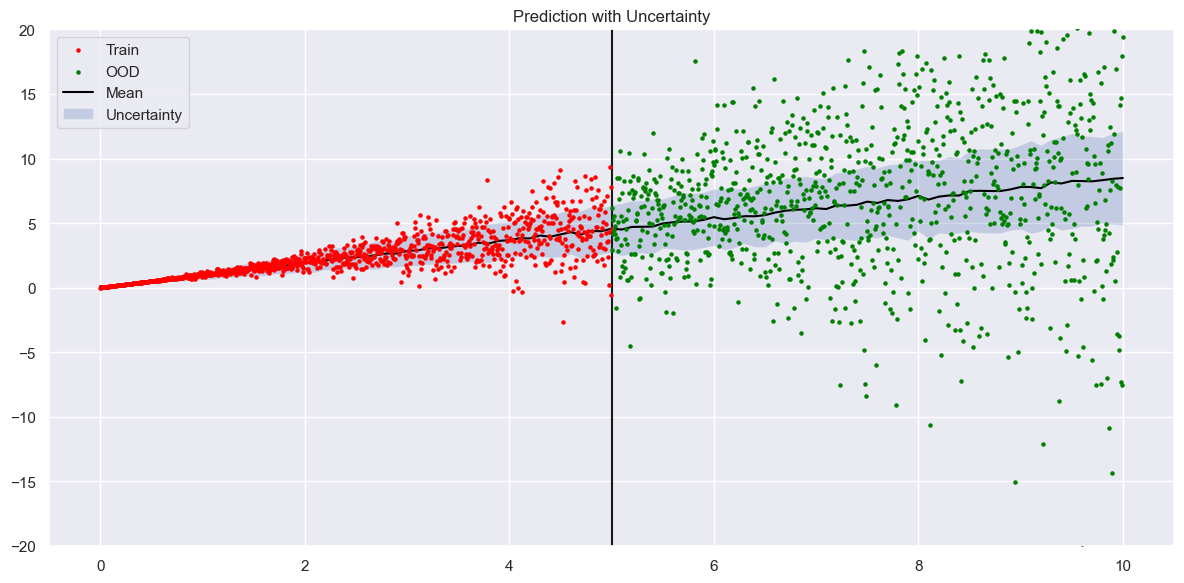

In [15]:
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
plt.scatter(X_ood, y_ood, color="green", zorder=10, label="OOD", s=5)
plt.plot(x_sample, y_mean, color="black", label="Mean")
plt.fill_between(x_sample, y_mean - n_std * y_std, y_mean + n_std * y_std, alpha=0.25, label="Uncertainty")
plt.ylim([-20, 20])
plt.legend(loc="upper left")
plt.axvline(x=5, color='k')
plt.title('Prediction with Uncertainty')
plt.tight_layout()
plt.show()

Thus, it shows that there may be two types of uncertainties, one coming from the model (epistemic) and one coming from the data (aleatoric).

In the out-of-distribution (OOD) region, epistemic uncertainty should be low since the underlying model is quite simple (linear). However, aleatoric uncertainty should be increasing as noise on the data increases.

## III. Other studies

Let's remove noise from the data and see what happens:

In [16]:
# Define the function to be modeled
def f(x):
    return x + 0.1 * x ** 2

# Generate input data
X = np.linspace(0, 5, num=1000, endpoint=True)

# Generate target data using the function f(x)
y = f(X)

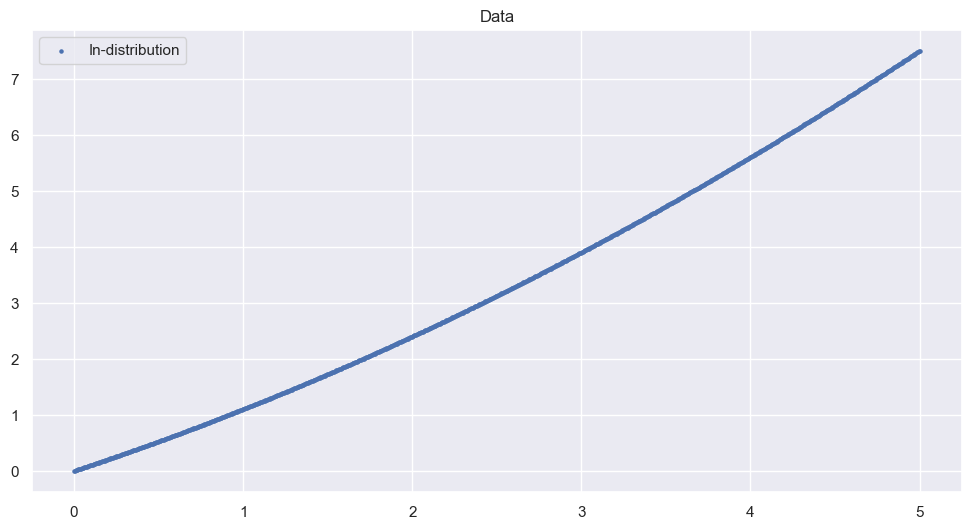

In [17]:
# plot 
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, s=5, label="In-distribution")
plt.legend()
plt.title("Data")
plt.show()

Let's train the model on the data:

In [18]:
model = MC_Dropout_net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas=(0.9, 0.999))
criterion = nn.MSELoss()

for i in tqdm.tqdm(range(1_000)):
    model.train()
    optimizer.zero_grad()
    
    # create a batch
    batch_x, batch_y = make_batch(X.shape[0], 32, X, y)
    
    # forward pass
    preds = model(batch_x)
    
    # calculate loss
    loss = criterion(preds, batch_y)
    
    # backward pass
    loss.backward()
    
    # update parameters
    optimizer.step()
    
    # print loss
    if i % 100 == 0:
        print("Epoch: {0}, Loss: {1}".format(i, loss.item()))

  2%|▏         | 20/1000 [00:00<00:05, 192.62it/s]

Epoch: 0, Loss: 21.948902130126953


 14%|█▎        | 135/1000 [00:00<00:03, 223.74it/s]

Epoch: 100, Loss: 0.5956716537475586


 23%|██▎       | 231/1000 [00:01<00:03, 234.46it/s]

Epoch: 200, Loss: 0.8923883438110352


 33%|███▎      | 327/1000 [00:01<00:02, 236.64it/s]

Epoch: 300, Loss: 0.43150895833969116


 45%|████▍     | 447/1000 [00:01<00:02, 236.80it/s]

Epoch: 400, Loss: 0.4489108622074127


 54%|█████▍    | 544/1000 [00:02<00:01, 239.25it/s]

Epoch: 500, Loss: 0.9005146026611328


 64%|██████▍   | 641/1000 [00:02<00:01, 239.42it/s]

Epoch: 600, Loss: 0.4395660161972046


 74%|███████▎  | 737/1000 [00:03<00:01, 238.74it/s]

Epoch: 700, Loss: 0.2609598934650421


 83%|████████▎ | 834/1000 [00:03<00:00, 239.04it/s]

Epoch: 800, Loss: 0.20199206471443176


 93%|█████████▎| 930/1000 [00:03<00:00, 236.53it/s]

Epoch: 900, Loss: 0.30135321617126465


100%|██████████| 1000/1000 [00:04<00:00, 233.47it/s]


In [19]:
samples = 100
# compute predictions

# Get Unknown dataset and test
x_sample = np.arange(0, 10 + 0.1, 0.1)
X_sample = np.reshape(x_sample, [x_sample.shape[0], 1])

X_sample_tensor = torch.from_numpy(X_sample).float().to(device)

In [20]:
iters_uncertainty = 200

n_std = 2 # number of standard deviations to plot
outputs, y_mean, y_std = uncertainity_estimate(X_sample_tensor, model, iters_uncertainty)

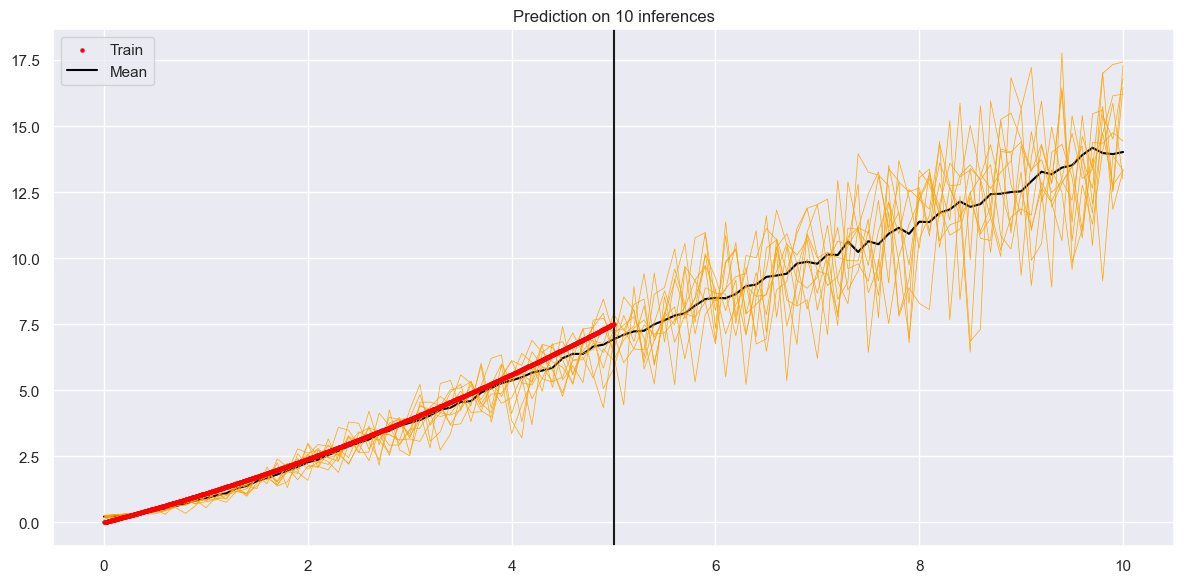

In [21]:
# plot
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
# plt.scatter(X_test, y_test, color="blue", zorder=10, label="Test", s=5)
plt.plot(x_sample, y_mean, color="black", label="Mean")

for i in range(10):
    plt.plot(x_sample, outputs[:, i], color="orange", linewidth=0.5)

plt.legend(loc="upper left")
plt.axvline(x=5, color='k')
plt.title('Prediction on 10 inferences')
plt.tight_layout()
plt.show()

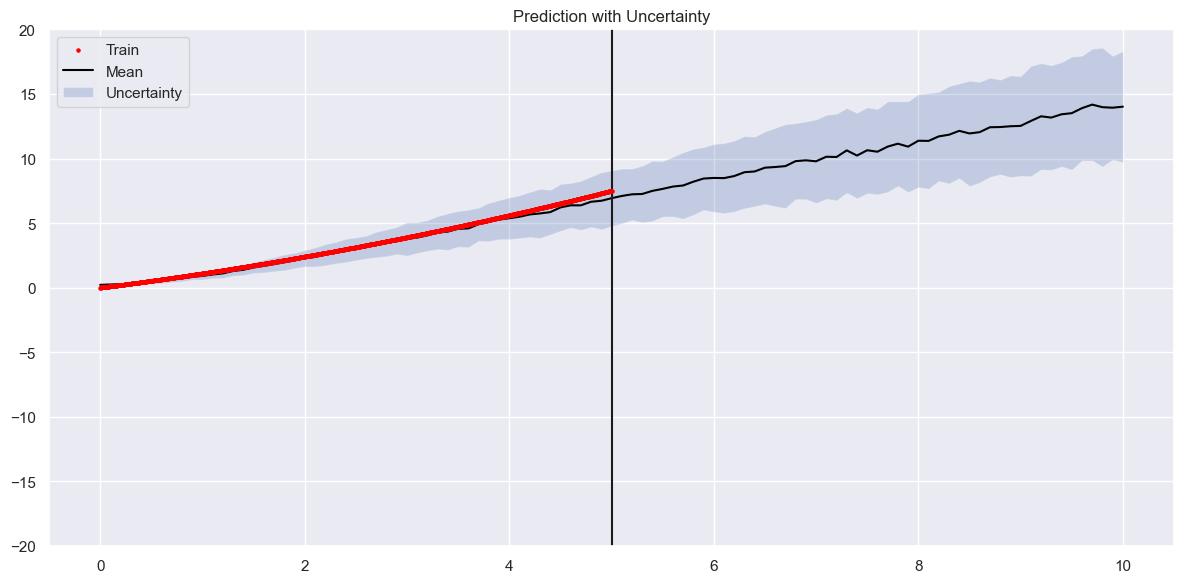

In [22]:
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
plt.plot(x_sample, y_mean, color="black", label="Mean")
plt.fill_between(x_sample, y_mean - n_std * y_std, y_mean + n_std * y_std, alpha=0.25, label="Uncertainty")
plt.ylim([-20, 20])
plt.legend(loc="upper left")
plt.axvline(x=5, color='k')
plt.title('Prediction with Uncertainty')
plt.tight_layout()
plt.show()

This time, the data does not have any noise, thus the uncertainty comes only from the model. This is called epistemic uncertainty.

In regions where the model has not seen any data, the uncertainty keeps increasing has the model has no knowledge on what happens in this region and fails to generalize.

This is shown in the following figure:

In [23]:
# Generate input data
X_ood = np.linspace(5, 10, num=1000, endpoint=True)

# Generate target data using the function f(x)
y_ood = f(X_ood)

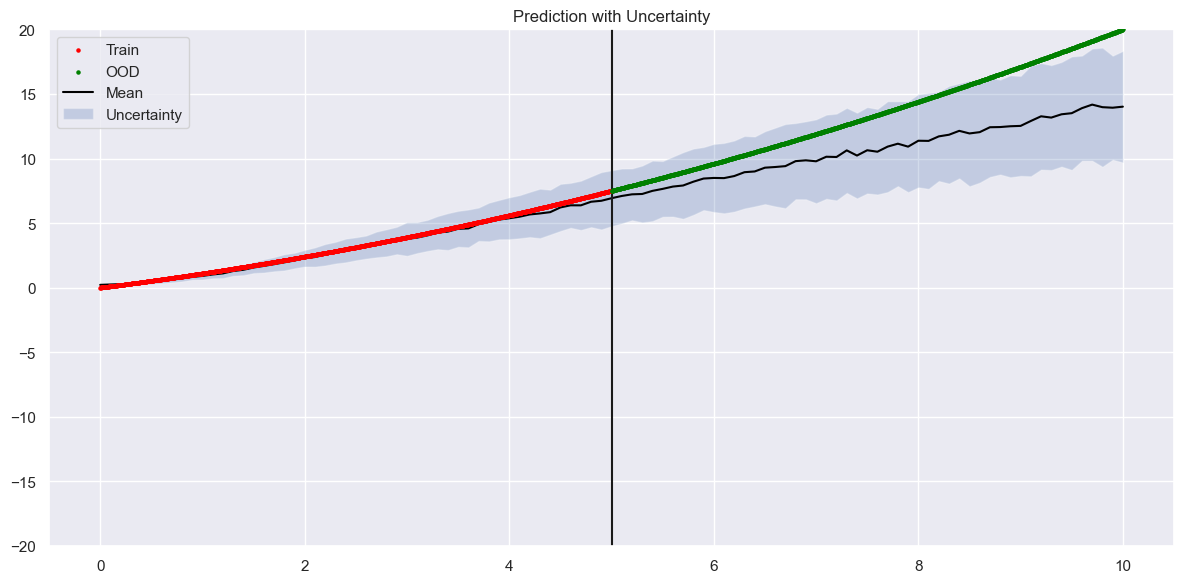

In [24]:
sns.set(rc={'figure.figsize':(12, 6)})
plt.scatter(X, y, color="red", zorder=10, label="Train", s=5)
plt.scatter(X_ood, y_ood, color="green", zorder=10, label="OOD", s=5)
plt.plot(x_sample, y_mean, color="black", label="Mean")
plt.fill_between(x_sample, y_mean - n_std * y_std, y_mean + n_std * y_std, alpha=0.25, label="Uncertainty")
plt.ylim([-20, 20])
plt.legend(loc="upper left")
plt.axvline(x=5, color='k')
plt.title('Prediction with Uncertainty')
plt.tight_layout()
plt.show()